In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# Load

## All-cells

In [2]:
meta_data <- readRDS('../../data/cache/cell_df_Mar30_2020.rds')



## tissue-defined clusters

In [3]:
fib <- list()
fib$synovium <- readRDS('../../data/cache/synovium_fibroblasts_obj.rds')
fib$lung <- readRDS('../../data/cache/lung_fibroblasts_obj.rds')
fib$salivarygland <- readRDS('../../data/cache/salivarygland_fibroblasts_obj.rds')
fib$gut <- readRDS('../../data/cache/fibroblast_object_gut.rds')


In [4]:
fib$synovium$meta_data <- fib$synovium$meta_data %>% 
    dplyr::mutate(tissue_cell_type = case_when(
        tissue_cell_type == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cell_type
    ))


In [5]:
effects <- fib %>% map('presto') %>% map('effects')

## Public datasets

In [6]:
## Adult Human Cell Atlas
effects_ahca <- readRDS('../../data/AdultHumanCellAtlas/cache/presto_cluster_nested.rds')
effects_ahca$padj <- p.adjust(effects_ahca$pvalue, 'BH')
effects_ahca$contrast <- gsub('mesenchymal', 'fibroblast', effects_ahca$contrast)
effects_ahca$Cluster <- gsub('mesenchymal', 'fibroblast', effects_ahca$Cluster)

pb_ahca <- readRDS('../../data/AdultHumanCellAtlas/cache/pseudobulk.rds')
pb_ahca$meta_data$Tissue <- pb_ahca$meta_data$tissue


In [7]:
effects_ts <- readRDS('../../data/tabula_sapiens/presto_cluster_nested.rds')
effects_ts$padj <- p.adjust(effects_ts$pvalue, 'BH')
# effects_ahca$contrast <- gsub('mesenchymal', 'fibroblast', effects_ahca$contrast)
# effects_ahca$Cluster <- gsub('mesenchymal', 'fibroblast', effects_ahca$Cluster)

pb_ts <- readRDS('../../data/tabula_sapiens/pb.rds')
pb_ts$exprs_norm  <- normalizeData(pb_ts$counts_mat, 1e4, 'log')
pb_ts$meta_data$Tissue <- pb_ts$meta_data$Organ
pb_ts$meta_data$CellType <- pb_ts$meta_data$Compartment

# AHCA + TS Heatmap

In [8]:
## Get all labels to assign colors 
all_tissues <- c(
    as.character(unique(pb_ts$meta_data$Tissue)), 
    unique(pb_ahca$meta_data$Tissue)
) %>% unique

all_clusters <- c(
    as.character(unique(pb_ts$meta_data$CellType)), 
    unique(pb_ahca$meta_data$CellType)
) %>% unique

# colors <- c(tableau_color_pal()(10), 'grey')
# glue("\t{all_clusters} = \'{colors}\',") %>% writeLines

# colors <- tableau_color_pal('Tableau 20')(17)
# glue("\t{all_tissues} = \'{colors}\',") %>% writeLines

# writeLines(paste(glue("\'{all_tissues}\'"), collapse = ','))



In [9]:
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 6))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 6))

do_heat <- function(pb, .title='') {
    ## Synchronize names 
    pb$meta_data <- pb$meta_data %>% dplyr::mutate(CellType = case_when(
        CellType %in% c('Endothelial', 'endothelial') ~ 'Endothelial',
        CellType %in% c('Stromal', 'stromal', 'mesenchymal') ~ 'Stromal',
        CellType %in% c('mural_muscle', 'muscle_mural') ~ 'Mural_Muscle',
        CellType %in% c('Epithelial', 'epithelial') ~ 'Epithelial',
        CellType %in% c('Immune', 'immune') ~ 'Immune'
    ))

    ## Plot the top variable genes in the matrix 
    genes <- apply(pb$exprs_norm, 1, sd) %>% sort(TRUE) %>% head(1000) %>% names()
    X <- pb$exprs_norm[genes, ] %>% t %>% scale %>% t
    colnames(X) <- with(pb$meta_data, paste(CellType, Tissue))

    fig.size(6, 8)
    res <- Heatmap(show_column_names = FALSE, 
        X, show_row_dend = FALSE, show_row_names = FALSE, use_raster = TRUE,
        top_annotation = columnAnnotation(df = pb$meta_data[, c('CellType', 'Tissue')], col=palette_heatmap, show_annotation_name=FALSE), 
        name = 'Scaled\nlog\nCP10K', column_title = .title
    )    
    res <- grid.grabExpr(draw(res, padding = unit(c(1, 1, 1, 15), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings
#     res <- grid.grabExpr(draw(res))
    res <- wrap_elements(full = res)
    return(res)
}



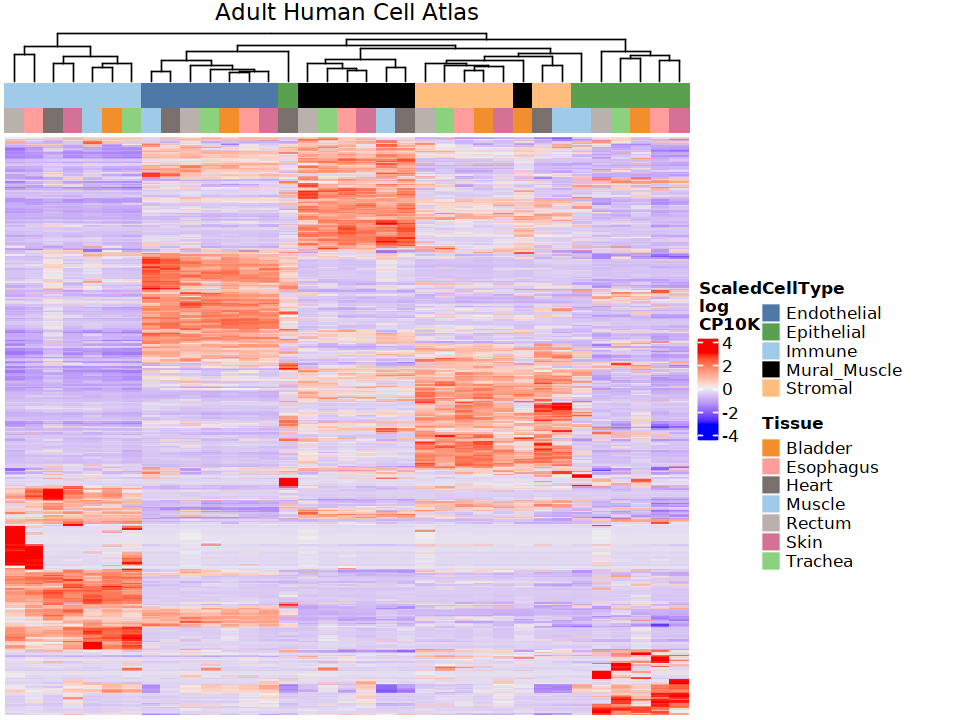

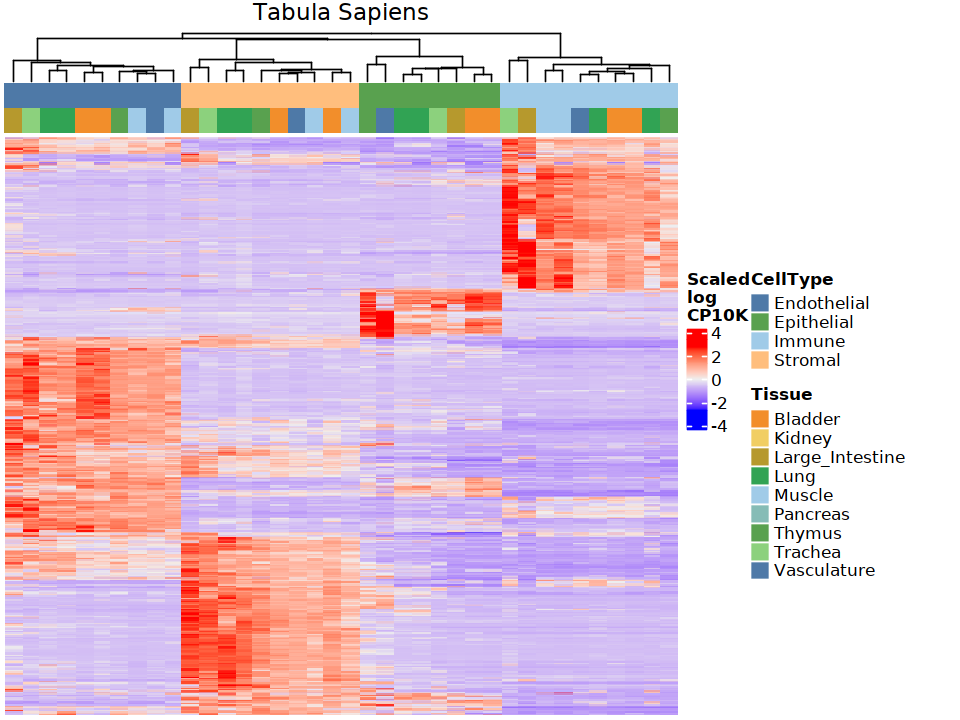

In [10]:
(p1 <- do_heat(pb_ahca, 'Adult Human Cell Atlas'))
(p2 <- do_heat(pb_ts, 'Tabula Sapiens'))


# ACHA + TS barplots

In [11]:
nshared <- data.table(effects_ts)[
    ## marker is upregulated in all tissues for that cluster
    , sum(padj < .05 & beta > 0), by = .(Cluster, feature)
][V1 > 1 & Cluster == 'Stromal'] %>% nrow

genes <- data.table(effects_ts)[
    ## marker is upregulated in all tissues for that cluster
    , sum(padj < .05 & beta > 0), by = .(Cluster, feature)
][V1 == 1 & Cluster == 'Stromal', feature]

df_ts <- data.table(effects_ts)[
    ## marker is upregulated in all tissues for that cluster
    padj < .05 & beta > 0 & feature %in% genes & Cluster == 'Stromal', .N, by = Tissue
] %>% 
#     rbind(tibble(Tissue = 'SHARED', N = nshared)) %>% 
    rbind(
        data.table(effects_ts)[
            ## marker is upregulated in all tissues for that cluster
            , sum(padj < .05 & beta > 0), by = .(Cluster, feature)
        ][V1 > 1 & Cluster == 'Stromal'][, .N, by = V1][, .(Tissue = sprintf('%d tissues', V1), N)][]
#         ][V1 > 1 & Cluster == 'Stromal'][, .N, by = V1][, .(Tissue = sprintf('Shared by %d tissues', V1), N)][]
    ) %>% 
    dplyr::mutate(Study = 'Tabula Sapiens')
            
df_ts


Tissue,N,Study
<chr>,<int>,<chr>
Thymus,349,Tabula Sapiens
Bladder,237,Tabula Sapiens
Lung,90,Tabula Sapiens
Trachea,71,Tabula Sapiens
Large_Intestine,186,Tabula Sapiens
Vasculature,2,Tabula Sapiens
Muscle,1,Tabula Sapiens
5 tissues,183,Tabula Sapiens
4 tissues,141,Tabula Sapiens


In [12]:
nshared <- data.table(effects_ahca)[
    ## marker is upregulated in all tissues for that cluster
    , sum(padj < .05 & beta > 0), by = .(Cluster, feature)
][V1 > 1 & Cluster == 'fibroblast'] %>% nrow

genes <- data.table(effects_ahca)[
    ## marker is upregulated in all tissues for that cluster
    , sum(padj < .05 & beta > 0), by = .(Cluster, feature)
][V1 == 1 & Cluster == 'fibroblast', feature]

df_ahca <- data.table(effects_ahca)[
    ## marker is upregulated in all tissues for that cluster
    padj < .05 & beta > 0 & feature %in% genes & Cluster == 'fibroblast', .N, by = tissue
] %>% 
#     rbind(tibble(tissue = 'SHARED', N = nshared)) %>% 
    rbind(
        data.table(effects_ahca)[
            ## marker is upregulated in all tissues for that cluster
            , sum(padj < .05 & beta > 0), by = .(Cluster, feature)
        ][V1 > 1 & Cluster == 'fibroblast'][, .N, by = V1][, .(tissue = sprintf('%d tissues', V1), N)][]
#         ][V1 > 1 & Cluster == 'fibroblast'][, .N, by = V1][, .(tissue = sprintf('Shared by %d tissues', V1), N)][]
    ) %>% 
    dplyr::mutate(Study = 'Adult Human Cell Atlas') %>% 
    dplyr::rename(Tissue = tissue)

df_ahca

Tissue,N,Study
<chr>,<int>,<chr>
Esophagus,708,Adult Human Cell Atlas
Skin,88,Adult Human Cell Atlas
Muscle,27,Adult Human Cell Atlas
Rectum,61,Adult Human Cell Atlas
Trachea,60,Adult Human Cell Atlas
Heart,107,Adult Human Cell Atlas
Bladder,6,Adult Human Cell Atlas
7 tissues,256,Adult Human Cell Atlas
6 tissues,179,Adult Human Cell Atlas


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


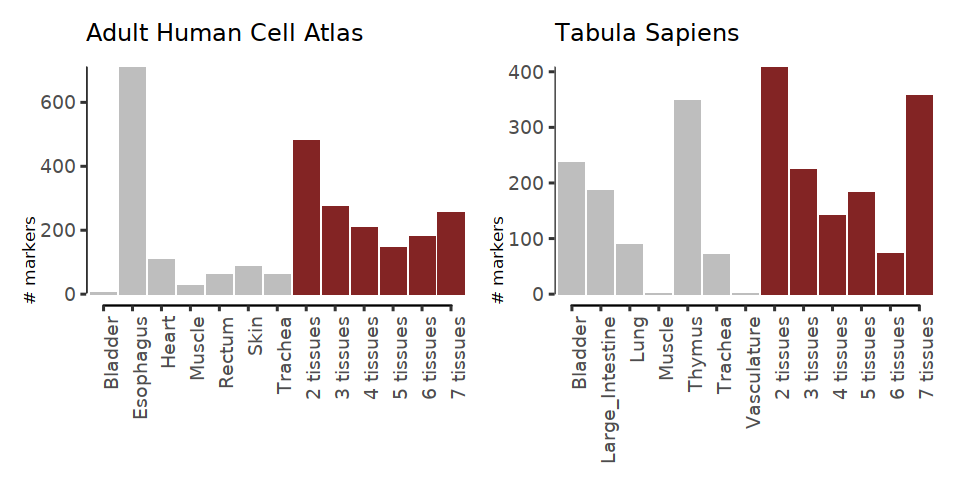

In [13]:
foo <- function(.df, .subtitle) {
    ggplot(.df, aes(reorder(Tissue, grepl('^\\d', Tissue)), N, fill = grepl('^\\d', Tissue))) + 
#     ggplot(aes(reorder(Tissue, N), N, fill = grepl('Shared', Tissue))) + 
        geom_bar(stat = 'identity') + 
        theme_tufte(base_size = 14) + geom_rangeframe() + 
        labs(x = '', y = '# markers', fill = 'Category', subtitle = .subtitle) +  
        scale_fill_manual(values = c('grey', muted('red'))) + 
#         scale_fill_manual(values = c(muted('red'), 'grey', muted('blue'))) + 
#         labs(title = 'Adult Human Cell Atlas') + 
#         facet_wrap(~Study, scales = 'free_x') + 
        guides(fill = FALSE) + 
        theme(
            axis.text.x = element_text(angle = 90, hjust = 1), 
            axis.title.y = element_text(hjust=0),
            axis.title = element_text(size = 10)
        ) + 
#         facet_grid(~Study, scales='free', space='free') + 
        NULL
    
}
# p3 <- bind_rows(list(df_ahca, df_ts)) %>% 
# bind_rows(list(df_ahca, df_mca, df_tm, df_ts)) %>% 
#     dplyr::mutate(Study = factor(Study, c('Adult Human Cell Atlas', 'Tabula Sapiens', 'Mouse Cell Atlas', 'Tabula Muris'))) %>% 
#     ggplot(aes(reorder(V1, V1), N, fill = label)) + 

# p3
fig.size(4, 8)
(p3 <- foo(df_ahca, 'Adult Human Cell Atlas')) | 
(p4 <- foo(df_ts, 'Tabula Sapiens'))


# Lung clinical stats

In [14]:
# openxlsx::readWorkbook(fname, 2)

,SampleID,InternalID,LibraryID,Diagnosis,Age,Sex,Serology,Treatment,Supplemental.O2,TLC,DLCO,Disease.Stage
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,Lung1,207,BRI207,Control,NA,NA,negative,none,NA,NA,NA,NA
2,Lung2,209,BRI209,Control,NA,NA,negative,none,NA,NA,NA,NA
3,Lung3,202,BRI202,Control,NA,NA,negative,none,NA,NA,NA,NA
4,Lung4,204R,BRI204R,Control,NA,NA,negative,none,NA,NA,NA,NA
5,Lung5,205,BRI205,RA-ILD,NA,NA,negative,none,Yes,NA,NA,Later
6,Lung6,214,BRI214,IPF,61,F,negative,none,Yes,NA,NA,Later


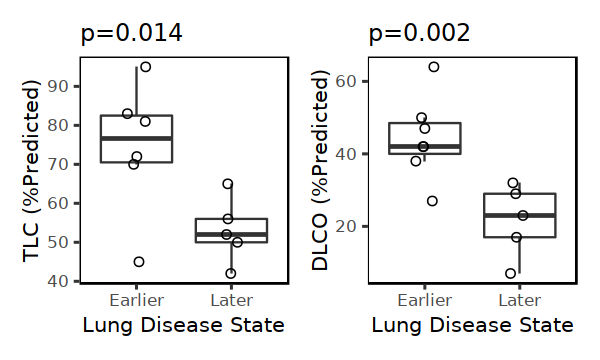

In [15]:
fname <- '../../manuscript/tables/clinical_tables.xlsx'
df <- openxlsx::readWorkbook(fname, 2) %>% 
    # left_join(
    #     fread('../../data/clinical/clinical_lung_tlc_dlco.txt')[, LibraryID := paste0('BRI', BRI)][, BRI := NULL][, .(LibraryID, DiseaseState=Early, TLC, DLCO)],
    #     by = 'LibraryID'
    # ) %>% 
    dplyr::mutate(
        # DiseaseState=case_when(
        #     Disease.Stage == 0 ~ 'Late',
        #     DiseaseState == 1 ~ 'Early'
        # ),
        TLC = as.integer(TLC),
        DLCO = as.integer(DLCO)
    )
    
head(df)

set.seed(42L)
plt1 <- df %>% 
    subset(!is.na(TLC)) %>% 
    ggplot(aes(Disease.Stage, TLC)) + 
        geom_boxplot(outlier.shape = NA) + 
        geom_point(shape = 21, size = 2, position=position_jitter(height = 0, width = .1)) + 
        labs(y = 'TLC (%Predicted)', x = 'Lung Disease State', subtitle = glue("p={round(broom::tidy(t.test(TLC~Disease.Stage, df, alternative = 'greater'))$p.value, 3)}")) + 
        NULL

plt2 <- df %>% 
    subset(!is.na(DLCO)) %>% 
    ggplot(aes(Disease.Stage, DLCO)) + 
        geom_boxplot(outlier.shape = NA) + 
        geom_point(shape = 21, size = 2, position=position_jitter(height = 0, width = .1)) + 
        labs(y = 'DLCO (%Predicted)', x = 'Lung Disease State', subtitle = glue("p={round(broom::tidy(t.test(DLCO~Disease.Stage, df, alternative = 'greater'))$p.value, 3)}")) + 
        NULL



p_e <- wrap_elements(full = (plt1 | plt2))
fig.size(3, 5)
p_e

# percent mito (OLD)

In [16]:
# fig.size(13, 6)
# p1 <- data.table(meta_data)[
#     , pm_med := median(percent_mito), by = LibraryID
# ][] %>% 
#     ggplot(aes(100 * percent_mito, reorder(LibraryID, pm_med), fill = Tissue)) + 
#         geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
#         geom_vline(xintercept = c(.2), linetype = 2) + 
#         facet_grid(Tissue~., scales = 'free', space = 'free') + 
#         theme(legend.position = 'bottom') + 
#         theme(
#             axis.title.y = element_blank(),
# #             axis.text.y = element_blank(),
#             axis.ticks.y = element_blank()
#         ) + 
#         guides(fill = FALSE) + 
#         labs(x = 'Percent mitochondrial reads') + 
#         NULL

# p1


# nGenes (OLD)

In [17]:
# fig.size(13, 6)
# p2 <- data.table(meta_data)[
#     , nGene_med := median(nGene), by = LibraryID
# ][] %>% 
#     ggplot(aes(nGene, reorder(LibraryID, nGene_med), fill = Tissue)) + 
#         geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
#         scale_x_continuous(trans = 'log10') + 
#         geom_vline(xintercept = c(500, 1000), linetype = 2) + 
#         facet_grid(Tissue~., scales = 'free', space = 'free') + 
#         theme(legend.position = 'bottom') + 
#         theme(
#             axis.title.y = element_blank(),
#             axis.text.y = element_blank(),
#             axis.ticks.y = element_blank()
#         ) + 
#         labs(x = 'Number unique genes') + 
#         NULL

# p2


# singlets/doublets (OLD)

In [18]:
# fig.size(13, 6)
# p3 <- data.table(meta_data)[
#     !is.na(scDblFinder.class), sum(scDblFinder.class == 'doublet') / .N, by = .(LibraryID, Tissue)    
# ][
#     , stat_med := median(V1), by = LibraryID
# ][] %>% 
#     ggplot(aes(100 * V1, reorder(LibraryID, stat_med), fill = Tissue)) + 
#         geom_bar(stat = 'identity') + 
#         facet_grid(Tissue~., scales = 'free', space = 'free') + 
#         theme(legend.position = 'bottom') + 
#         labs(x = 'Percent Doublets') + 
#         theme(
#             axis.title.y = element_blank(),
#             axis.text.y = element_blank(),
#             axis.ticks.y = element_blank()
#         ) + 
#         guides(fill = FALSE) + 
#         NULL

# p3


# Barplots

In [19]:
dname <- '../../data/cache/all_obj_all/'
fields_load <- c('meta_data', 'clusters_df')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [20]:
Clusters <- obj$clusters_df[, 1]
obj$meta_data$Lineage <- case_when(
    Clusters %in% c('5', '6', '0') ~ 'Fibroblast',
    Clusters %in% c('10') ~ 'Mural',
    Clusters %in% c('12', '7', '8') ~ 'Epithelial',
    Clusters %in% c('13') ~ 'Glial',
    Clusters %in% c('3', '4') ~ 'Endothelial',
    Clusters %in% c('9') ~ 'Plasma',
    Clusters %in% c('1', '2', '11') ~ 'Leukocyte'   
) 


In [21]:
plt_df <- obj$meta_data %>% 
    dplyr::mutate(Type = case_when(
        Lineage %in% c('Fibroblast', 'Endothelial', 'Mural') ~ 'Stromal', 
        TRUE ~ 'Non-Stromal'
    )) %>% 
    with(table(Tissue, Lineage, Type)) %>% 
    data.table() %>% 
    subset(N > 0) 


In [22]:
lineage_levels <- plt_df %>% 
    dplyr::select(Lineage, Type) %>% 
    unique() %>% 
    arrange(Type) %>% 
    with(Lineage)

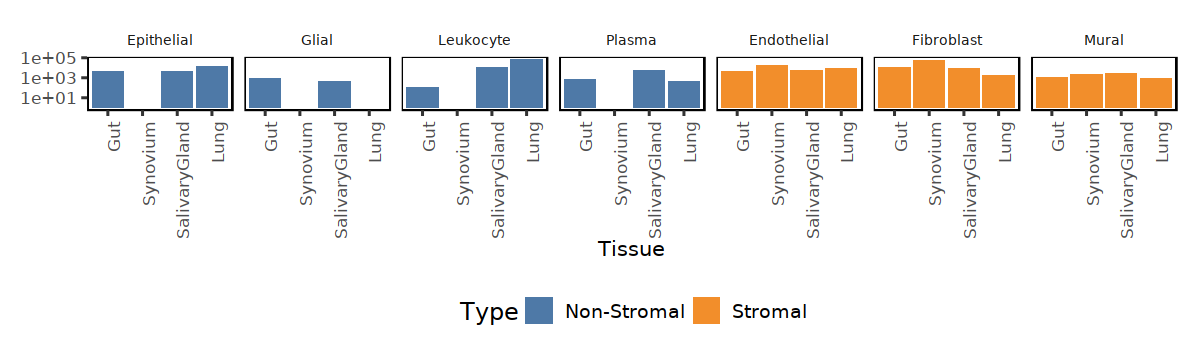

In [23]:
fig.size(3, 10)
p5 <- plt_df %>% 
    dplyr::mutate(Lineage = factor(Lineage, lineage_levels)) %>% 
    dplyr::mutate(Tissue = factor(Tissue, rev(c('Lung', 'SalivaryGland', 'Synovium', 'Gut')))) %>% 
    ggplot(aes(Tissue, N, fill = Type)) + 
        geom_bar(stat = 'identity') + 
#         geom_bar(stat = 'identity', position = position_fill()) + 
#         scale_fill_tableau('Tableau 10') + 
#         coord_flip() + 
#         guides(fill = FALSE) + 
#         labs(y = 'Ratio of cells') + 
        theme(
            axis.title.y = element_blank(),
            legend.position = 'bottom', 
            axis.text.x = element_text(angle = 90, hjust = 1),
            strip.text = element_text(size = 8)
        ) + 
        facet_wrap(~Lineage, nrow = 1) + 
        scale_y_log10() + 
        scale_fill_tableau() + 
        labs(y = 'Number cells') + 
        NULL



pg <- ggplotGrob(p5)

for(i in which(grepl("^strip", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

p5 <- wrap_elements(pg)
p5


# Tissue-defined corplot

In [24]:
effects <- fib %>% map('presto') %>% map('effects')

all_genes <- effects %>% 
    map('feature') %>% 
    map(unique) %>% 
    reduce(intersect)


effects_all <- effects %>% 
    map(dplyr::select, -pvalue) %>% ## old p-values were one-tailed 
    map(dplyr::mutate, pvalue = 2 * exp(pnorm(abs(zscore), log.p = TRUE, lower.tail = FALSE))) %>% 
    bind_rows(.id = 'Tissue') %>%
    subset(!Cluster %in% c('DOUBLET', 'LOWQC', 'UNKNOWN', 'NOTCH3+ perivascular')) %>% 
    subset(feature %in% all_genes) ## only keep genes in all datasets


In [25]:
# genes_shared <- data.table(effects_all)[beta > 0.5 & pvalue < .01, .SD[1], by = .(feature, Tissue)][, .N, by = feature][N > 1, feature]
# length(genes_shared)
genes_shared <- data.table(effects_all)[beta > 0.5 & pvalue < .01, unique(feature)]
length(genes_shared)

plt_mat <- effects_all %>% 
#     subset(Cluster %in% markers_all$Cluster) %>% 
    subset(feature %in% genes_shared) %>% 
    dplyr::select(feature, Cluster, Tissue, zscore) %>% 
    tidyr::unite(Tissue_Cluster, Tissue, Cluster) %>% 
    tidyr::spread(Tissue_Cluster, zscore) %>% 
    tibble::column_to_rownames('feature') %>% 
    t() %>% scale %>% t %>% cor()

dim(plt_mat)


# hr <- -plt_mat %>% as.dist %>% hclust %>% as.dendrogram()
set.seed(10)
# hr <- plt_mat %>% pmax(0) %>% t %>% scale %>% t %>% dist %>% hclust %>% as.dendrogram()
hr <- plt_mat %>% pmax(0) %>% dist %>% hclust %>% as.dendrogram()
# hr <- plt_mat %>% scale %>% dist %>% hclust %>% as.dendrogram()
# hr <- plt_mat %>% dist %>% hclust %>% as.dendrogram()
.x <- dendextend::cutree(hr, 5)
gene_clusters <- LETTERS[.x]
names(gene_clusters) <- names(.x)
# LETTERS[dendextend::cutree(hr, 8)]
table(gene_clusters)
head(gene_clusters)

[1] 2575

[1] 17 17

gene_clusters
A B C D E 
3 2 4 5 3 

gut_Inflammatory Fibroblasts           gut_Myofibroblasts 
                         "A"                          "B" 
                  gut_RSPO3+            gut_WNT2B+ Fos-hi 
                         "C"                          "C" 
         gut_WNT2B+ Fos-lo 2                 gut_WNT5B+ 1 
                         "D"                          "E"

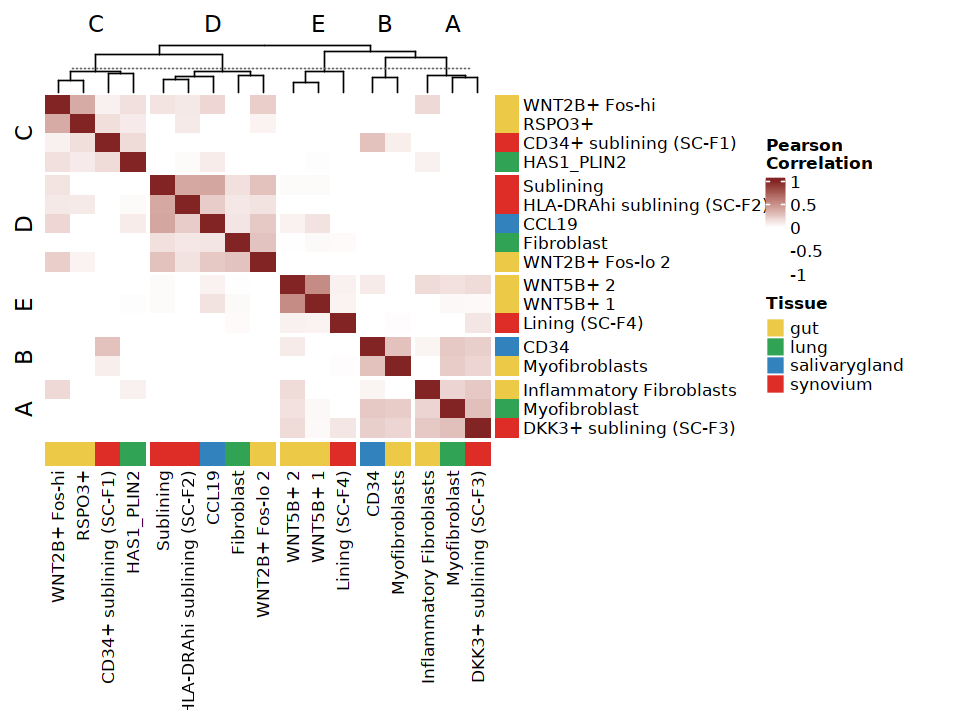

In [26]:
fig.size(6, 8)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))

h0 <- Heatmap(
#     show_row_names = FALSE,          
    matrix = plt_mat, 
    name = 'Pearson\nCorrelation',
#     plt_mat %>% t %>% cor(), 
    row_labels = gsub('^(.*?)_(.*)', '\\2', rownames(plt_mat)), 
    column_labels = gsub('^(.*?)_(.*)', '\\2', rownames(plt_mat)), 
    colorRamp2(c(-1, 0, 1), c('white', 'white', muted('red'))),    
#     column_names_rot = 45, 
    show_row_dend = FALSE,
    right_annotation = rowAnnotation(
        df = data.frame(Tissue = gsub('^(.*?)_(.*)', '\\1', rownames(plt_mat))),
        show_legend = TRUE, 
        show_annotation_name = FALSE,
        col = palette_heatmap
#         annotation_legend_param = list(legend_direction = 'horizon')
    ),
    bottom_annotation = columnAnnotation(
        df = data.frame(Tissue = gsub('^(.*?)_(.*)', '\\1', rownames(plt_mat))),
        show_legend = FALSE, 
        show_annotation_name = FALSE,
#         annotation_legend_param = list(legend_direction = 'horizontal'),
        col = palette_heatmap
    ),
#     column_split = 8,
#     row_split = 8
#     heatmap_legend_param = list(
#         legend_direction="horizontal"
# #         legend_side = 'bottom_right'
# #         legend_side = c('bottom', 'right')
#     ),
    column_split = gene_clusters,
    row_split = gene_clusters
)

# f0 <- grid.grabExpr(draw(h0, heatmap_legend_side = 'bottom'))
f0 <- grid.grabExpr(draw(h0))


fig.size(6, 8)
f0 <- grid.grabExpr(draw(h0, padding = unit(c(1, 1, 1, 13), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings
wrap_elements(f0)



# Per-library tissue-defined cluster barplots 

In [27]:
meta_data_fib <- readRDS('../../data/cache/obj_fibroblasts/meta_data.rds')

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


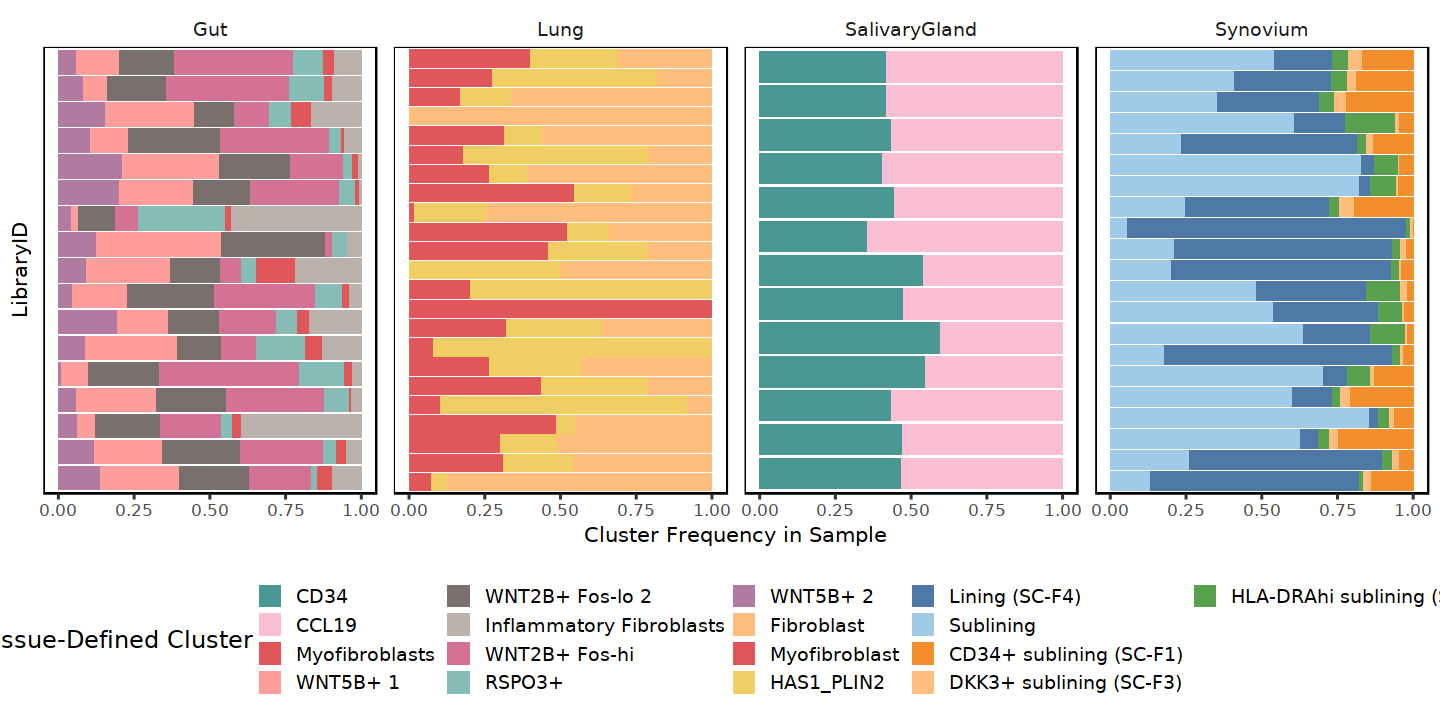

In [28]:
fig.size(6, 12)
f1 <- meta_data_fib %>% 
    with(table(LibraryID, Tissue, tissue_cluster)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
#     dplyr::mutate(tissue_cluster = glue('({Tissue}) {tissue_cluster}')) %>% 
    ggplot(aes(LibraryID, N, fill = tissue_cluster)) + 
        geom_bar(stat = 'identity', position = position_fill()) + 
        scale_fill_manual(values = palette_global[unique(meta_data_fib$tissue_cluster)]) + 
        theme(axis.text.y= element_blank(), axis.ticks.y = element_blank()) + 
#         facet_grid(Tissue~., scales = 'free', space = 'free') + 
        facet_wrap(~Tissue, nrow=1, scales = 'free_y') + 
        coord_flip() + 
        theme(legend.position = 'bottom') + 
        labs(fill = 'Tissue-Defined Cluster', y = 'Cluster Frequency in Sample') + 
        guides(fill = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 2)), alpha = FALSE) + 
        NULL
f1

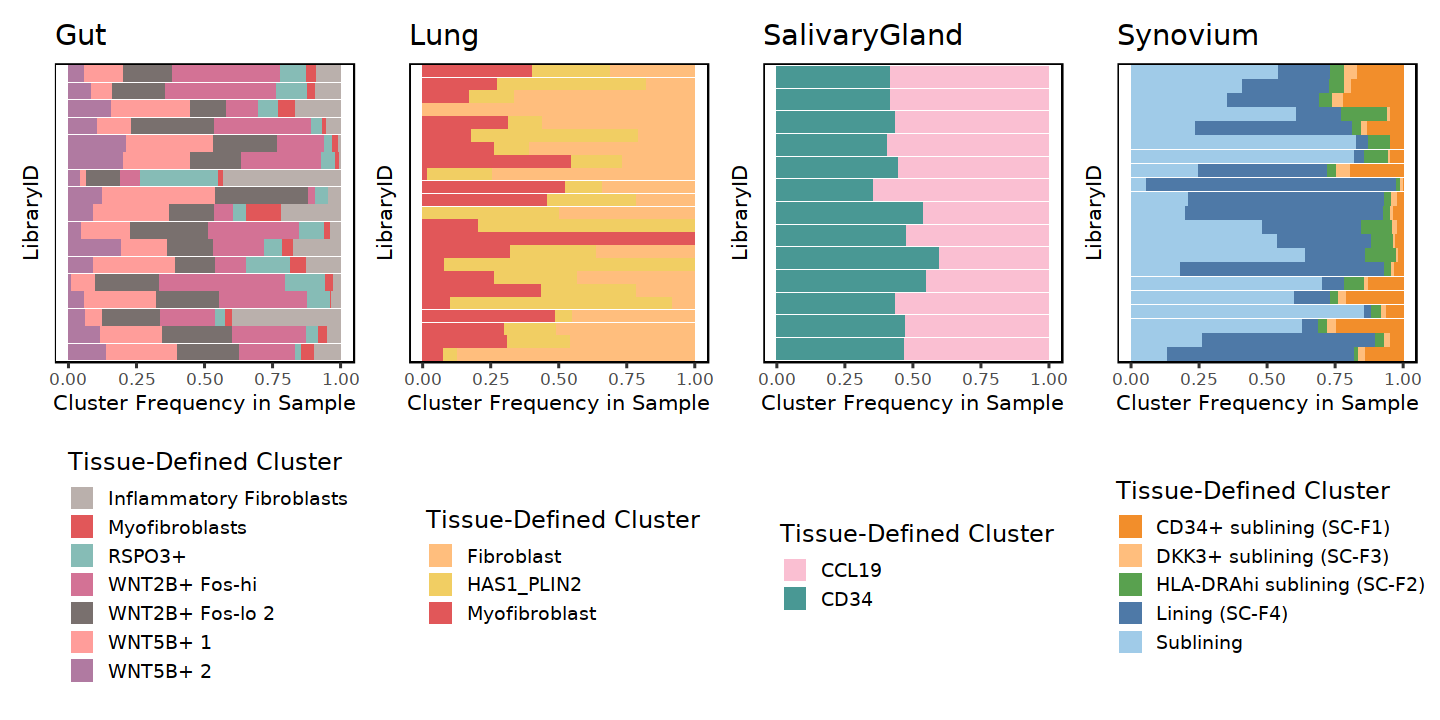

In [29]:
fig.size(6, 12)
f1 <- meta_data_fib %>% 
    with(table(LibraryID, Tissue, tissue_cluster)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
#     dplyr::mutate(tissue_cluster = glue('({Tissue}) {tissue_cluster}')) %>% 
    split(.$Tissue) %>% 
    imap(function(.SD, .tissue) {
        ggplot(.SD, aes(LibraryID, N, fill = tissue_cluster)) + 
            geom_bar(stat = 'identity', position = position_fill()) + 
            scale_fill_manual(values = palette_global[unique(.SD$tissue_cluster)]) + 
#             scale_fill_manual(values = palette_global[unique(meta_data_fib$tissue_cluster)]) + 
            theme(axis.text.y= element_blank(), axis.ticks.y = element_blank()) + 
    #         facet_grid(Tissue~., scales = 'free', space = 'free') + 
#             facet_wrap(~Tissue, nrow=1, scales = 'free_y') + 
            coord_flip() + 
            theme(
                legend.position = 'bottom',
                legend.box = 'vertical',
                legend.direction = 'vertical'
            ) + 
            labs(fill = 'Tissue-Defined Cluster', y = 'Cluster Frequency in Sample') + 
            labs(title = .tissue) + 
            guides(fill = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 2)), alpha = 'none') + 
            NULL        
    }) %>% 
    purrr::reduce(`+`) + 
    plot_layout(nrow = 1)


f1


# Cartoon

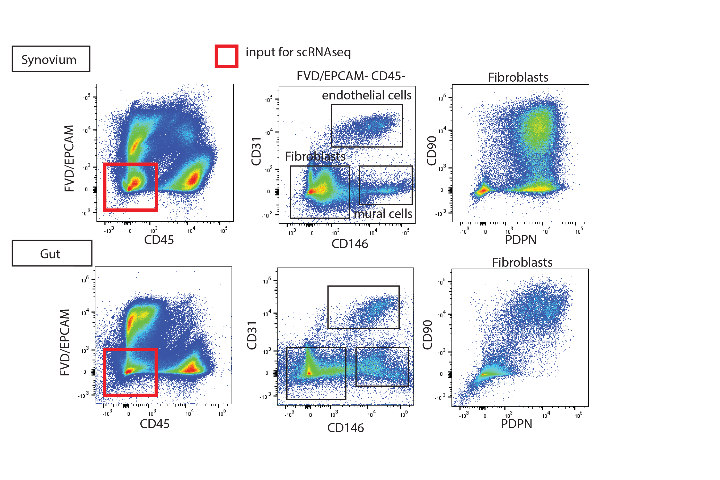

In [30]:
library(png)
g0 <- readPNG('../../manuscript/figures/cartoon_facs.png') %>% 
    rasterGrob(interpolate = TRUE)

fig.size(4, 6)
wrap_elements(g0)

# Panels

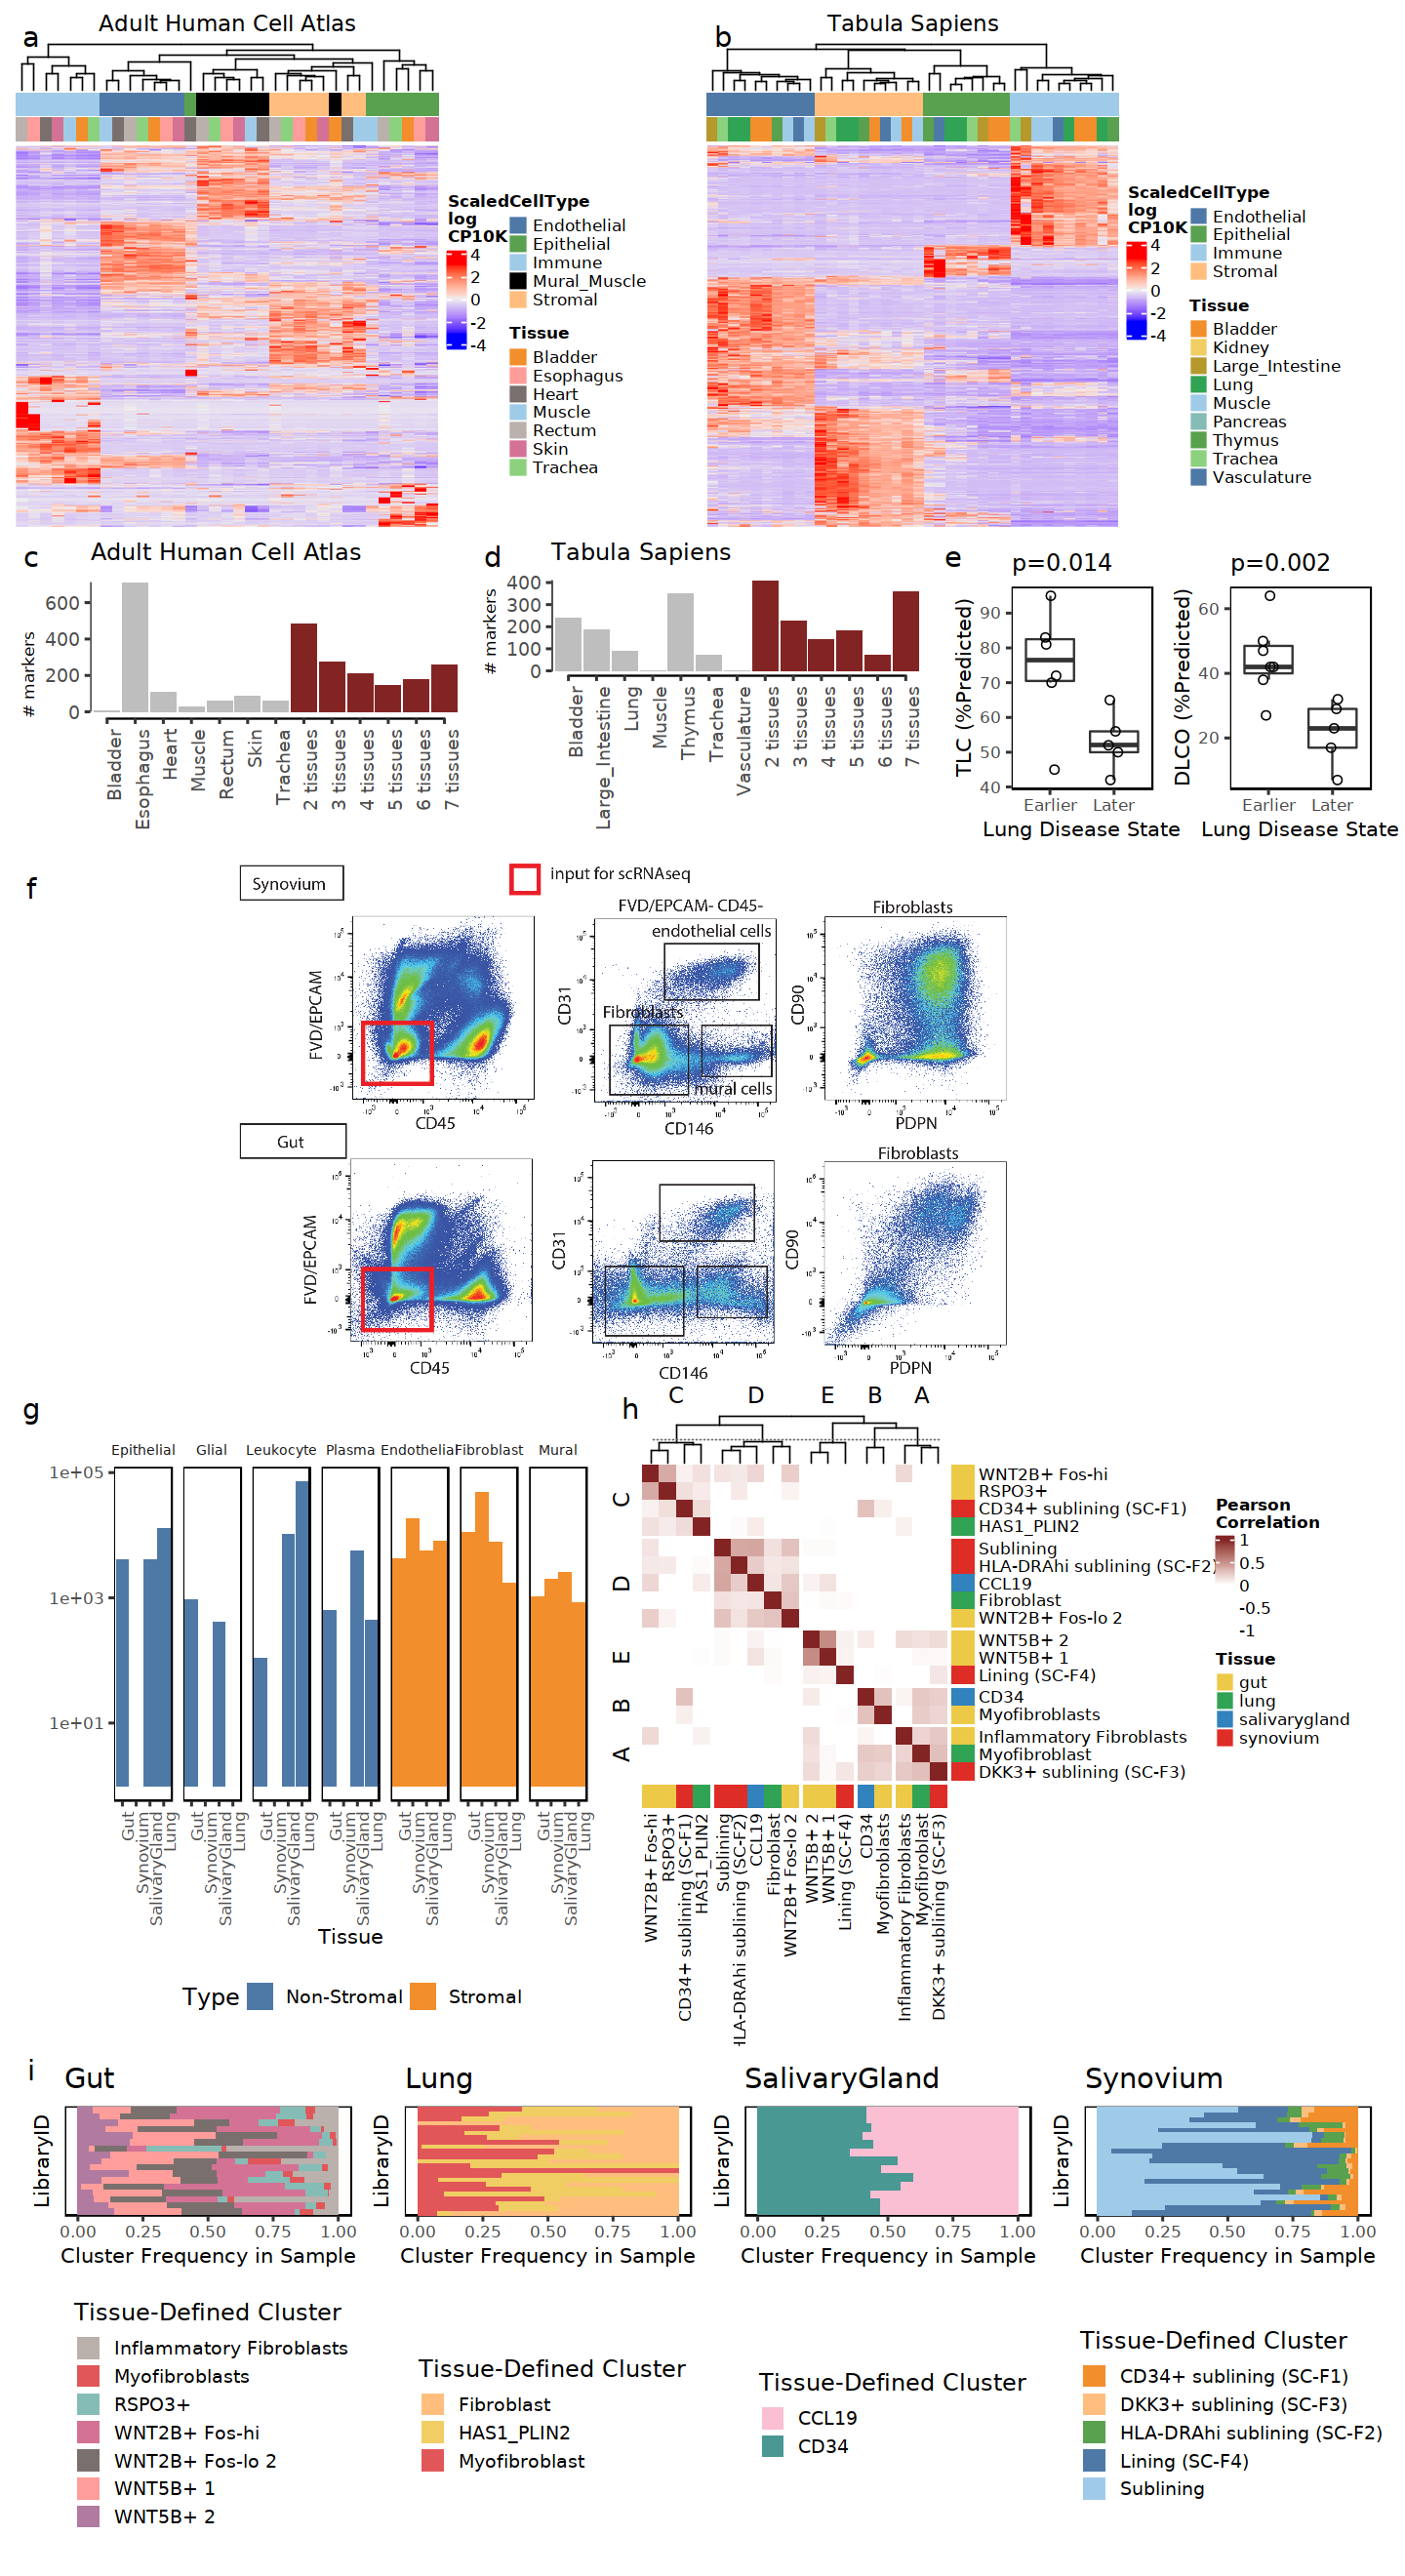

In [31]:
fig.size(22, 12)
fig <- (
    (
        ## row1
        (p1 | p2)
    ) / 
    (
        ## row2
        (wrap_elements(full = p3) | wrap_elements(full = p4) | p_e) 
            
            # (p_e | wrap_elements(full = g0)) + plot_layout(widths = c(1, 3))

        #         (
#             (wrap_elements(full = p3) / wrap_elements(full = p4)) | 
#             wrap_elements(full = g0) 
            
# #             (wrap_elements(full = p3) | wrap_elements(full = p4) | wrap_elements(full = p5)) + 
# #             plot_layout(widths = c(1, 1, 1.5))
            
#         ) 
    ) /
    (
        wrap_elements(full = g0)
        
    ) / 
    (
        ## row3
        (p5 | wrap_elements(full = f0)) + 
        plot_layout(widths = c(1.5, 2))
    ) / 
    (
        ## row4
        wrap_elements(full = f1)
        
    )
) + 
    plot_layout(heights = c(1, .6, 1, 1.3, 1)) + 
    plot_annotation(tag_levels = 'a') 

fig 

In [32]:
ggsave(
    filename = '../../manuscript/figures/SuppFigure1.pdf', 
    plot = fig, 
    units = 'in', device = 'pdf', 
    height = 22, width = 12,
    useDingbats = FALSE
)

